<hr style="border:1px solid gray">

# Welcome to an Overview of Unsupervised Machine Learning for Astronomy! 
### <font color="#E74C3C"> Stella Offner, Associate Professor & Josh Taylor, Postdoctoral Fellow </font>
 
<!--### <font color="#E74C3C"> Josh Taylor, Postdoctoral Fellow </font> -->

July 18, 2022
<hr style="border:1px solid gray">



#### We have organized this tutorial to: 
1. Give you exposure to some basic terminology in Machine Learning & Statistics 
2. Dive deeper into the main concepts of Unsupervised Machine Learning and how they can be of use
3. Test these concepts on a simple but well-known toy dataset for which we have ground truth 
4. Apply these techniques to a dataset obtained by Spitzer of star-forming clouds, to showcase how unsupervised learning techniques can assist astronomy research. 

Some of these concepts may be very foreign to you at first, but we're here to help explain as we walk through them. Feel free to interrupt and ask questions!

<hr style="border:1px solid gray">

# Preliminaries

We will rely heavily on functionality exposed through `scikit-learn`, so let's make sure we all have working versions of the following modules. 

In [ ]:
## Load modules & settings 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.stats
import sklearn.datasets
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.manifold
import sklearn.cluster
import sklearn.mixture
import sklearn.metrics
import seaborn as sns
import umap

%matplotlib inline
sns.set_style('white')

<hr style="border:1px solid gray">

# <font color="#e7a23c">1</font>  Background - What is Machine Learning?

Machine Learning is a framework to allow computers to **solve common data analysis problems without explicit step-by-step instructions**. ML is highly inter-disciplinary, combining data modeling (from statistics) and model fitting (from applied mathematics) into efficient, scalable algorithms for easy use (computer science). Typically, statistics is used again to help us interpret what and how well the machine has "learned". 

ML is pervasive in our modern world, supporting everything from facial recognition, recommendation systems (e.g. Netflix / Spotify queues, IG / FB feeds), cancer diagnosis, robot autonomy ... this list is very large and growing everyday.  

## <font color="#e7a23c">1.1</font> Supervised Learning 

All of the problems mentioned above belong to a subfield of ML called **Supervised Machine Learning**, where the goal is to learn to accurately predict some known label $Y$ associated with the data $X$. Ex: 
- Data $X$ might be what you're currently viewing on IG + your viewing history. Label $Y$ is whether you like / dislike your feed
- Data $X$ could be characteristics of a tissue sample from medical biopsy. Label $Y$ is whether the sample is malignant or benign

These examples have *discrete* labels (like/dislike, malignant/benign), but supervised ML also includes *regression* (or *curve fitting*) type problems, where $Y$ is assumed to take continuous values. An example from basic statistics: find the best coefficients $\beta$ to satisfy the linear relationship between $X$ and $Y$, $Y \sim X\beta + \text{error}$. 


## <font color="#e7a23c">1.2</font> Unsupervised Learning 

But **what do you do if your data $X$ has no label $Y$???** 

Can you still learn anything from it? Data analysis in this domain is known as **Unsupervised Machine Learning**, and will be our focus today. 

UML is a crucial step in Exploratory Data Analysis, encompassing: 
1. Histograms / density estimation 
2. Visualization of high-dimensional data
3. Clustering / pattern recognition 

UML can be thought of as trying to achieve the same outcomes as Supervised ML *without the benefit of the labels* to build or train the model. Since the labels typically inform both model design and fitting for supervised learning, this "missing data" make UML tasks more difficult to design, parameterize, assess, etc. Essentially, we're trying to look for something "interesting" in our data, without knowing what constitutes "interesting" in this setting.

To overcome this hurdle, UML typically relies on a multi-pronged learning approach combining [1]+[2]+[3] above. If each individual approach points to the same conclusions we gain confidence about what we learn from the data. Today, you will learn some basics of UML to help with future data analyses. 

These learning techniques are useful in a variety of settings, even if your ultimate goal is supervised learning. For example, 
- [This recent study](https://www.science.org/doi/10.1126/science.abm5847) utilized clustering techniques to discover new subcategories of RNA viruses, essentially expanding the set of known types of viruses, which led to filling in some gaps in the theory of how viruses evolve. 
- [This astronomy study](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.1408M/abstract) uses unsupervised ML to classify galaxy images based on their morphology. 
- [This recent paper](https://ui.adsabs.harvard.edu/abs/2022arXiv220101781G/abstract) by one of Stella's postdocs uses unsupervised ML (clustering with an algorithm called DBSCAN) to identify clusters inside star-forming regions within STARFORGE simulations of molecular clouds. 

If you are interested in learning more about ML used in astronomy applications, see this [2020 review by Fluke and Jacbos](https://ui.adsabs.harvard.edu/abs/2020WDMKD..10.1349F/abstract). 

<hr style="border:1px solid gray">

# <font color="#e7a23c">2</font> Getting Started with the Wine Dataset 

To learn how to use the UML techniques mentioned above we will work with a commonly used dataset called [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html), which measures various chemical / visual characteristics of wine made from three different kinds of Italian grapes (these are our labels): Barolo, Grignolino, and Barbera. 

We will not use the grape labels directly for the machine learning below, but we will take advantage of them to help explain how the algorithms work. 

Load & inspect the wine dataset from `scikit-learn`.  The 13 data columns contain quantitative measuresments of 178 different wines, each made from one of the three grapes. 

In [ ]:
## Cell 2.1

## Load the wine data, strip out the names of the data variables (the measurements), 
## convert integer encoding of grape label to actual grape names
wine, grape = sklearn.datasets.load_wine(as_frame=True, return_X_y=True)
winecols = wine.columns
wine['grape'] = grape.map({0:'Barolo', 1:'Grignolino', 2:'Barbera'})

display(wine)
wine.describe().applymap(lambda x: f"{x:0.2f}")

Before proceeding with further analysis it is generally a good idea to *standardize* or normalize your dataset in some way. From the above, we can see the `alcohol` content measurement ranges from 11-14, the `nonflavanoid_phenols` is in the 0-1 range, and `proline` has values in 200-1700. These wildly different scales can cause havoc for ML algorithms, so we need to equalize the range data variables. **Standardization** is one way of accomplishing this, which replaces its variable with its **Statistical Z-score**: 
$$
z_i = \frac{x_i - mean(\{x_i\})}{sd(\{x_i\})}
$$
`sklearn` has built-in functionality to do this: 

In [ ]:
## Cell 2.2

# Only standardize the data, not the labels. 
wine[winecols] = sklearn.preprocessing.StandardScaler().fit_transform(wine[winecols])

# Check that the resulting means are ~= 0, standard deviations ~= 1 after Z-score transformation
wine.describe().applymap(lambda x: f"{x:0.2f}")

<hr style="border:1px solid gray">

## <font color="#e7a23c">3</font> Density Estimation for Exploratory Data Analysis 

### <font color="#e7a23c">3.1</font> Background on Data Distributions & Their Probability Functions

Statistical modeling assumes our data $X$ is a sample from some unknown probability distribution. We describe the distributions with mathematical functions with special properties: 

- ***Probability density functions*** (pdfs) are usually denoted $f(x)$, and quantify the relative likelihood of observing data with value $x$. Density functions are always $\geq 0$ and integrate to 1. 
- ***Probability distribution functions*** are usually denoted $F(x)$, and are related to the density via integration: $F(x) = \int_{-\infty}^x f(y) \, dy$. 

While they are not exactly the same thing, the words *density* and *distribution* are often used interchangeably because of the integral relationship. Don't get too bogged down with this today ... if we know one, we can find the other. The plots you see today will all be of probability densities. 

You have probably heard of the major probability distributions: the Uniform and Standard Gaussian (or Normal), whose 1-dimensional *probability density functions* (pdfs) are compared below. The height of a pdf shows us which values of data are more / less common, according to its distribution. 

In [ ]:
## Cell 3.1 
## Plotting 1-d pdfs of Uniform and Standard Gaussian Distributions:

# First define a grid of values on which to evaluate each pdf. 
# Use the range [-3,3] because that covers the bulk of the range of Std. Gaussian
xmin = -3; xmax = 3
xgrid = np.linspace(xmin, xmax, 100)

# Evaluate & plot the pdfs of each along this grid 
plt.figure(figsize=(14,7))
sns.lineplot(x=xgrid, y=scipy.stats.uniform.pdf(xgrid, loc=xmin, scale=xmax-xmin));
sns.lineplot(x=xgrid, y=scipy.stats.norm.pdf(xgrid));
plt.title('Uniform[-3,3] + Standard Gaussian Probability Density Functions');
plt.legend(['Uniform','Gaussian']);

### <font color="#e7a23c">3.2</font> Estimating Unknown Density Functions from Data

When we do data analysis in the real world, we are almost never given a density function, but instead a **sample of data** (a dataset) assumed to be drawn from it.  Let's generate a random sample of 1000 points from both a Uniform and Standard Gaussian distribution in 2-dimensions to get an idea of what data from each distribution might look like. 

In [ ]:
## Cell 3.2 
## Generating a random sample from 2-dimensional Uniform and Gaussian probability distributions

# Sample 1000 points from each distribution. 
# "Seeding" is a way to constrain the random number generator on your computer so we all get the same results. 
np.random.seed(101)
unif = np.random.uniform(low=0, high=1, size=(1000,2))
gaus = np.random.normal(loc=0.0, scale=1.0, size=(1000,2))

# Visualize the data from each distribution as a scatterplot 
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
sns.scatterplot(x=unif[:,0],y=unif[:,1]).set(title='Sample (N=1000) of Uniformly Distributed Data in 2-d', xlabel='x1', ylabel='x2');
plt.subplot(1,2,2)
sns.scatterplot(x=gaus[:,0],y=gaus[:,1]).set(title='Sample (N=1000) of Gaussian Distributed Data in 2-d', xlabel='x1', ylabel='x2');

Histograms are one way to help us estimate the unknown distribution of data (remember, we usually start with a sample of data, not a density!). 

When we compute & plot histograms along each dimension (column / variable) of a multivariate dataset (i.e., more than 1-dimension), we are viewing an estimate of the **marginal distributions** of a dataset. 

In [ ]:
## Cell 3.3
## Plot histograms for each dimension of the datasets we randomly sampled above 
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.histplot(x=unif[:,0]).set(title='Histogram of Uniform Data, 1st Dim', xlabel='x1');
plt.subplot(2,2,2)
sns.histplot(x=unif[:,1]).set(title='Histogram of Uniform Data, 2nd Dim', xlabel='x2');
plt.subplot(2,2,3)
sns.histplot(x=gaus[:,0]).set(title='Histogram of Gaussian Data, 1st Dim', xlabel='x1');
plt.subplot(2,2,4)
sns.histplot(x=gaus[:,1]).set(title='Histogram of Gaussian Data, 2nd Dim', xlabel='x2');

**<font color="#E74C3C">Do these marginal distributions look like the true density we plotted above?</font>**

Kernel Density Estimates (KDEs) are smoother versions of histograms, capable of expressing more nuanced structure in data. 

In [ ]:
## Cell 3.4
## Plot KDEs for each dimension of our randomly sampled data 
## The seaborn function 'kdeplot' does all of the computation under the hood, returning a plot 
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.kdeplot(x=unif[:,0]).set(title='KDE of Uniform Data, Dim 1', xlabel='x1');
plt.subplot(2,2,2)
sns.kdeplot(x=unif[:,1]).set(title='KDE of Uniform Data, Dim 2', xlabel='x2');
plt.subplot(2,2,3)
sns.kdeplot(x=gaus[:,0]).set(title='KDE of Gaussian Data, Dim 1', xlabel='x1');
plt.subplot(2,2,4)
sns.kdeplot(x=gaus[:,1]).set(title='KDE of Gaussian Data, Dim 2', xlabel='x2');

**<font color="#E74C3C">Do you think the marginal KDEs look more or less like the true density functions we plotted above?</font>**

Since our made up data is 2-dimensional, we can also compute & visualize a **bivariate kernel density estimate**, which is a heatmap of the estimated probability density of our sample, evaluated across the $(x,y)$ plane: 

In [ ]:
## Cell 3.5 
## Visualize bivariate KDEs, usually these are more informative than marginals 
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
sns.kdeplot(x=unif[:,0],y=unif[:,1],fill=True).set(title='Bivariate KDE of Uniform Data', xlabel='x1', ylabel='x2');
plt.subplot(1,2,2)
sns.kdeplot(x=gaus[:,0],y=gaus[:,1],fill=True).set(title='Bivariate KDE of Gaussian Data', xlabel='x1', ylabel='x2');

**<font color="#E74C3C">Can you tell where most of the data lies in 2-d for each distribution?</font>**

**<font color="#E74C3C">Which distribution has more dispersion (spread)?</font>**



### <font color="#e7a23c">3.3</font> Quick Density Visualizations for the wine data 

Seaborn plotting allows us to quickly inspect the marginal distributions of our wine data, along with pairwise scatterplots of each of its dimensions. This **pairs plot** gives us a peek into what's happening in this 13-dimensional dataset.  

Below, we will tell Seaborn to color each set of wine measurements (the rows of our data frame) by its known grape label. The density estimates are computed by group (each type of grape). 

In [ ]:
## Cell 3.6
## View scatterplots of the pair-wise associations of wine measurements 
## Here, we color by known grape variety to get an idea of how the grape might influence pairwise associations.
## A pairplot can be a bit slow, just be patient. 
pl = sns.pairplot(data=wine, hue='grape', palette=sns.cubehelix_palette(3), diag_kind='kde', vars=winecols);
pl.map_lower(sns.kdeplot, fill=True);

**<font color="#E74C3C">What do you see?</font>**
- Do the statistics for each grape (color) appear different? If so, this indicates that our known labels correspond to some **real and measurable** groupings within the data. 
- Do some variables (measurements) appear highly correlated? Correlation usually makes ML tasks easier. 
- Do any of the marginal distributions (along the diagonal of the appear skewed (one tail longer than the other in the KDE plots)?  Skew usually makes ML tasks harder. 

**<font color="#E74C3C">How Exploratory Analysis influences Unsupervised ML:</font>**

The above exploratory analysis for wine gives us a rough of what kind of results we might reasonably expect from a machine learning algorithm applied to the data. Example: if we do some ML on wine, and an algorithm tells us there are three groups in the data, would you believe those results? What if it tells us there are 10 groups? No groups? 

<hr style="border:1px solid gray">

## <font color="#e7a23c">4</font> Dimension Reduction for Data Visualization

Each of the wines in our dataset had 13 measurements taken from it (stored in the rows of our data frame), thus our data is 13-dimensional. Even though this is relatively low by modern data standards, it is still difficult to "see" (plot) this data. The pairwise scatterplots above are an attempt at peeking into the data, but this is not a complete analysis: 
- Pair plots quickly become unwieldy as dimension grows
- Pair plots only convey pairwise relationships. In higher-d datasets, we expect relationships might encompass more than 2 dimensions. 

As an alternative, statisticians and mathematicians have developed ways to reduce high-d datasets down to 2-d or 3-d for visualization purposes.  These methods are unsupervised learning techniques for **dimension reduction** (DR), which is also known as **embedding** high-d data in a lower-dimensional space. It is also sometimes called **manifold learning**, based on the idea that, typically, the interesting "structure" in a high-d dataset lies on some (unknown) lower-d mathematical *manifold*. This is all terminology for the same thing, don't get bothered by it right now. 

All DR algorithms attempt to minimize some measurable difference between data in high-d space, and the resulting embedding in low-d (2-d) space. There are many ways of characterizing differences in these spaces, which give rise to the various different DR methods. (read about the ones available in `scikit-learn` [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [here](https://scikit-learn.org/stable/modules/manifold.html). 

We will exercise 3 of the more common DR methods on our wine data: 
1. **P**rincipal **C**omponents **A**nalysis (PCA)  
Produces an embedding whose total statistical variance is as close as possible to the variance of the original high-d data. 
2. **t**-distributed **S**tochastic **N**eighbor **E**mbedding (tSNE)  
Models the similarity of each pair of high-d data points with a Gaussian distribution, and the similarity of each pair of low-d embedded points with the [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) (which is like a Gaussian, but with fatter tails / more outliers). tSNE minimizes a probabilistic characterization of the difference between these two distributions known as [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). 
3. **U**niform **M**anifold **A**pproximation and **P**rojection  
Very similar to tSNE, but uses a different probability distribution to model pair-wise similarities in low-d space, and minimizes a different type of probabilistic distance between the high- and low-d distributions known as [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy). 

We will not dive into the deeper details of each method as it gets pretty complicated (especially UMAP), but we can produce their embeddings of our 13-d wine data and see what structures appear. Because we have labels, we will use them to color each point to see how well the embeddings respect known group structure. 

In [ ]:
## Cell 4.1
## Create PCA, tSNE, and UMAP embeddings of the wine data. 
# Use default parameters for each. 
# The tSNE function throws several warnings about future updates, you can ignore them
wine[['pca1','pca2']] = sklearn.decomposition.PCA(n_components=2).fit_transform(wine[winecols])
wine[['tsne1','tsne2']] = tsne = sklearn.manifold.TSNE(n_components=2, random_state=123).fit_transform(wine[winecols])
wine[['umap1','umap2']] = umap.UMAP(n_components=2, random_state=123).fit_transform(wine[winecols])

In [ ]:
## Cell 4.2
## Plot embedded wine data, with points colored by their grape variety 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1', y='pca2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='wine PCA Embedding');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1', y='tsne2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='wine TSNE Embedding');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1', y='umap2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='wine UMAP Embedding');

**<font color="#E74C3C">What do you see?</font>**
- Can you pick out groups ("clusters") in the wine data from these embeddings, even if you didn't have the color distinctions to help you? 
- Looking at the organization of colors, did the embeddings respect the integrity of our known groups (grapes)? 
- Do any wines appear to be mapped to the "wrong" spot in any of the embeddings? 

**<font color="#E74C3C">Caveat 1:</font>**

These methods of DR are all popular, but there is still some debate as to what you can **justifiably interpret** from them. 

For instance, PCA & UMAP produced a fairly similar horseshoe-shaped embedding, while t-SNE lined the data up along a line. Does this shape indicate anything to us? Does the fact that tSNE put the Barbera grape group at top right while PCA/UMAP placed them (bottom)left mean anything? We don't know yet (research is ongoing). 

However, it is generally accepted that, assuming you set the algorithm's parameters correctly, any "structure" you perceive from an embedding indicates something worth investigating further. 

**<font color="#E74C3C">Caveat 2:</font>**

Most embedding methods require the user to set a parameter that roughly controls how many high-d neighbor relationships should be preserved in low-d, which is not an intuitive parameter to set. If your embedding looks weird (too spread out, or too concentrated) you should play with this parameter to see if it helps. These look OK so we will not investigate this further here, but attempt on your own, just to get a feel for how each algorithm responds to its parameters. 

**<font color="#E74C3C">Caveat 3:</font>**

PCA is a *linear* projection from high-d to low-d, whereas tSNE/UMAP are highly *non-linear* projections. **If you know for sure** that the "structure" in your high-d data lies mostly along a linear subspace, PCA will always produce satisfactory embeddings and should be preferred over other methods, as it requires no user-supplied parameters (which, if set incorrectly, can produce garbage). However we rarely, if ever, know this about our data when we start analysis. 

<hr style="border:1px solid gray">

## <font color="#e7a23c">5</font> Data Clustering

**Clustering** is the process of separating the observations in a dataset into groups of items that are similar to each other in some way. Ideally, we want both **high intra-group similarities and high inter-group differences**, but this is usually optimistic for real-world data. You may also see this called **segmenting** or **partitioning** data, but it all refers to the same idea. 

The human brain is suprisingly good at perceiving groups from visual cues, such as the wine embeddings above, but picking out clusters "by eye" is tedious and usually lacks repeatability (so, not a good approach for science). As such, **many** clustering algorithms have been developed in ML to try and formalize the process of group identification. These algorithms attempt to mimic how we *think* our brains make these distinctions, differing in how they define the similarity / difference between two data points and two clusters. 

### <font color="#e7a23c">5.1</font> Types of Clustering Algorithms

There are two general classes of clustering algorithms: 
- **Discriminative** algorithms attempt to learn the location of boundaries between clusters (the blue dashed line, below-left). 
- **Generative** models attempt to learn the conditional probability distribution of each cluster (the class-specific probability densities, below-right). This is sometimes also called "model-based" clustering, since the algorithm learns a probability distribution (i.e., a statistical *model*).

In [ ]:
## Cell 5.1 
## Visualize examples of what Discriminative and Generative Clustering are "learning"

## First generate some toy random data with 2 different groups 
np.random.seed(101)
clusdata = pd.DataFrame()
clusdata['x'] = np.concatenate((np.random.normal(loc=-1.0, scale=1.0, size=500), np.random.normal(loc=5.0, scale=0.5, size=500)))
clusdata['y'] = np.random.uniform(low=-0.01, high=0.01, size=1000)
clusdata['label'] = np.concatenate((np.ones(500,dtype=int), 2*np.ones(500,dtype=int)))

## Visualize the data + cluster boundaries, as determined by each clustering method 
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
sns.scatterplot(x='x', y='y', hue='label', data=clusdata).set(title='Discriminative Clustering Boundary', ylim=[-0.1,0.5]);
plt.vlines(x=2.75, ymin=-0.5, ymax=0.5, ls='dashed');

plt.subplot(1,2,2)
sns.scatterplot(x='x', y='y', hue='label', s=20, data=clusdata).set(title='Generative Clustering Boundaries', ylim=[-0.1,0.5]);
sns.kdeplot(x='x', hue='label', ls='dashed', data=clusdata);

**<font color="#E74C3C">What defines the "clusters" in Discriminative Clustering? In Generative Clustering?</font>** 
    

### <font color="#e7a23c">5.2</font> Discriminative Clustering with K-means

Most clustering methods are discriminative. We will showcase K-means clustering, as it is the simplest to parameterize and most well-known outside of the ML community. `scikit-learn` has made [several others available](https://scikit-learn.org/stable/modules/clustering.html). One method on that list, DBSCAN, is also widely used, but harder to parameterize so we will focus on K-means in this tutorial. 

K-means attemps to find $K$ cluster centers $c_j, \, j \in \{1,\ldots,K\}$ which minimize the **S**um of **S**quared **E**rrors (SSE) between each data point $x_i$ and it's nearest cluster center $c_{i*}$, as measured by Euclidean distance. Mathematically we have, for $N$ data points in our training sample: 
$$
\begin{align}
c_{i*} &= \underset{j \in \{1,\ldots,K\}}{\operatorname{arg min}} ||x_i - c_j||^2
\\ SSE &= \sum\limits_{i=1}^N ||x_i - c_{i*}||^2
\end{align}
$$

A cluster of data, say cluster $j$, then comprises the set of points $\{x_i\}$ that are closest to $c_j$: $||x_i - c_j||^2 < ||x_i - c_k||^2 \, \forall \, j \, \neq \, k$. 

The algorithm works by: 

0. Initializing the set of centers $\{c_j\}$, usually by setting them equal to $K$ randomly selected data points, 
1. Computing $c_{i*}$ for each $x_i$, and updating each centers $c_j$ to be equal to the mean of all $x_i$ in cluster $j$. whose closest cluster center is $c_j$. 
2. Repeat (1.) until the set of centers ${c_j}$ stops changing much (convergence). 

This is a mathematically suboptimal way of optimizing SSE, so usually K-means is run several times with different initializations, and the run with lowest SSE is kept. `scikit-learn` does this for you under the hood via the `n_init` argument. 

In order to run K-means a user must first specify $K$ (the number of desired clusters to return). Let's run K-means on the wine data, using $K=3$ since we already know our data has 3 groups, and visualize the resulting clusters on our embeddings. 

In [ ]:
## Cell 5.2 
## Run K-means with number of desired clusters K=3 
## The .labels_ attribute stores the cluster membership for each point as integer codes 
wine['KM3'] = sklearn.cluster.KMeans(n_clusters=3, random_state=123, init='k-means++').fit(wine[winecols]).labels_

## Visualize the K-means cluster label of each point in embedded space
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1', y='pca2', hue='KM3', data=wine, palette='Set2').set(title='KMeans-3, PCA');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1', y='tsne2', hue='KM3', data=wine, palette='Set2').set(title='KMeans-3 TSNE');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1', y='umap2', hue='KM3', data=wine, palette='Set2').set(title='KMeans-3 UMAP');

## Reproduce the embedding colored by type of grape, for comparison 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1', y='pca2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='Truth PCA');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1', y='tsne2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='Truth TSNE');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1', y='umap2', hue='grape', data=wine, palette=sns.cubehelix_palette(3)).set(title='Truth UMAP');

**<font color="#E74C3C">Does the clustering seem to agree with our known groups?</font>**

**<font color="#E74C3C">What if we change $K$ to 5?</font>**

In [ ]:
## Cell 5.2b
## Run K-means with number of desired clusters K=5
## The .labels_ attribute stores the cluster membership for each point as integer codes 
wine['KM5'] = sklearn.cluster.KMeans(n_clusters=5, random_state=123, init='k-means++').fit(wine[winecols]).labels_

## Visualize the K-means cluster label of each point in embedded space
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1', y='pca2', hue='KM5', data=wine, palette='Set2').set(title='KMeans-5, PCA');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1', y='tsne2', hue='KM5', data=wine, palette='Set2').set(title='KMeans-5 TSNE');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1', y='umap2', hue='KM5', data=wine, palette='Set2').set(title='KMeans-5 UMAP');

### <font color="#e7a23c">5.3</font> Generative Clustering 

Generative clustering arises from statistical theory and permits relaxation of some of the implicit assumptions that K-means makes about our data clusters (more about this below). 

####  Mixture Models in Probability 
In probability and statistics, a **Mixture Model** for our data asserts that we can approximate its (unknown) probability density $f(x)$ by some convex combination of $K$ other densities $\{g_k(x)\}_{k=1}^K$. Collectively, the $g_k(x)$ serve as "building blocks" to approximate $f(x)$, in much the same way splines are used to approximate curves and  wavelets / sinusoids are used to approximate signals. $g_k(x)$ has its own parameters, which are determined during mixture model fitting ("training the model"). Thus, the statistical model for our data is: 
$$
\text{unknown } f(x) \approx \hat f(x) = \sum\limits_{k=1}^K \alpha_k g_k(x)
$$
The $\alpha_k$ are restricted to be $\geq 0$ and sum to 1, and are usually called **mixing weights**. The individual densities $g_k(x)$ are usually called **component densities**. 

#### Gaussian Mixtures for high-d Data 

When our data is 1-dimensional, we have many choices for the form of $g$, but for correlated data of arbitrary dimension $p$ there is really only one option: the **multivariate Gaussian distribution** denoted by $MVG(x \, | \, \mu,\Sigma)$, which is a function evaluated at $x$ given two parameters: 

- Mean vector $\mu$ (length = $p$), which gives the mean of the data in each dimension
- Covariance matrix $\Sigma$ (a $p \times p$ symmetric, positive definite matrix), specifying both the correlation of data amongst the dimensions and the spread/dispersion of data in each dimension.  

A mixture model whose $K$ components are MVGs is known as a **Gaussian Mixture Model**, and has the form: 
$$
\hat f(x) = \sum\limits_{k=1}^K \alpha_k MVG_k(x \, | \, \mu_k, \Sigma_k)
$$

#### Fitting GMMs

When modeling with GMMs, $\Sigma$ can be restricted to have various forms. Two commonly used forms are *full* covariances $\Sigma^f$, where every entry of $\Sigma$ is allowed to to be non-zero, and *diagonal* covariances $\Sigma^d$, where only the diagonal elements can be non-zero. 
$$
\Sigma^d = \begin{pmatrix}
\sigma_{1} & 0 & \cdots & 0\\
0 & \sigma_{2} & \cdots & 0 \\
\vdots & \vdots & \cdots & \vdots \\
0 & 0 & \cdots & \sigma_{p}
\end{pmatrix},
\qquad 
\Sigma^f = \begin{pmatrix}
\sigma_{1} & \sigma_{12} & \cdots & \sigma_{1p}\\
\sigma_{12} & \sigma_{2} & \cdots & \sigma_{2p} \\
\vdots & \vdots & \cdots & \vdots \\
\sigma_{1p} & \sigma_{2p} & \cdots & \sigma_{p}
\end{pmatrix}
$$
Usually when you start the modeling process, you don't know whether you should specify diagonal or full covariances in the model. Sometimes, this decision comes down to numerical feasibility: a model with many "free parameters" (the ones we have to specify through model fitting) requires more data to fit it well. We can count the # of free parameters for each type of GMM in $p$ dimensions: 
- \# of weight params = $K - 1$ (remember the $\alpha_k$s must sum to 1)
- \# of mean params = $K \times p$ 
- \# of covariance params = $K \times p$ (diag) or $K \times p(p+1)/2$ (full)
- total \# params $\sim$ $\mathcal{O}(Kp)$ (diag) or $\mathcal{O}(Kp^2)$ (full)

So, using a GMM with full covariance can require *a lot* of data in high dimensions. 

Fitting a GMM is not trivial, requiring simulatneous optimization over its set of unknown parameters $\{\alpha_k, \, \mu_k,\, \Sigma_k\}_{k=1}^K$ via an iterative optimization routine known as the [Expectation-Maximization Algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). 

#### Connecting GMMs with K-means 

Although not obvious from the above, K-means is tuned to find the best groups of data that sit in high-dimensional spheres. That is, it can only find groups that have spherical shapes. This is because the Euclidean metric $||x-y|| = r$ (as used above in K-means) defines a sphere of radius $r$ in whatever space the measure is taken. 

After doing lots of math, you can show that K-means is equivalent to a GMM with *spherical* covariance matrices, which have the form

$$
\Sigma^{\text{sphere}} =\begin{pmatrix}
\sigma & 0 & \cdots & 0\\
0 & \sigma & \cdots & 0 \\
\vdots & \vdots & \cdots & \vdots \\
0 & 0 & \cdots & \sigma
\end{pmatrix}
$$

for some constant diagonal entries $\sigma > 0$ (unlike $\Sigma^{d}$, which allows different $\sigma_i$ along its diagonal elements).

If your data has clusters that are spherically shaped, K-means works great! Although most datasets violate this assumption to some degree, K-means is still popular because of its simplicity. 

#### Fitting GMMs in Python
Luckily, `scikit-learn` exposes easy functionality for fitting GMMs, so let's try it on wine using mixture components with both diagonal and full covariance matrices. We'll use $K=3$ to start, since we know the truth in this exercise. 

In [ ]:
## Cell 5.3 
## Perform GMM clustering with K=3 

## Using a model with diagonal covariance matrices
wine['GMMd3'] = sklearn.mixture.GaussianMixture(n_components=3, 
                                            covariance_type='diag', 
                                            init_params='k-means++', 
                                            random_state=1234).fit(wine[winecols]).predict(wine[winecols])

## Using a model with full covariances
wine['GMMf3'] = sklearn.mixture.GaussianMixture(n_components=3, 
                                           covariance_type='full', 
                                           init_params='k-means++', 
                                           random_state=1234).fit(wine[winecols]).predict(wine[winecols])

 
## Visualize the GMM clusterings 
plt.figure(figsize=(21,14))
plt.subplot(2,3,1)
sns.scatterplot(x='pca1', y='pca2', hue='GMMd3', data=wine, palette='Set2').set(title='GMM3-Diag, PCA');
plt.subplot(2,3,2)
sns.scatterplot(x='tsne1', y='tsne2', hue='GMMd3', data=wine, palette='Set2').set(title='GMM3-Diag TSNE');
plt.subplot(2,3,3)
sns.scatterplot(x='umap1', y='umap2', hue='GMMd3', data=wine, palette='Set2').set(title='GMM3-Diag UMAP');
plt.subplot(2,3,4)
sns.scatterplot(x='pca1', y='pca2', hue='GMMf3', data=wine, palette='Set2').set(title='GMM3-Full PCA');
plt.subplot(2,3,5)
sns.scatterplot(x='tsne1', y='tsne2', hue='GMMf3', data=wine, palette='Set2').set(title='GMM3-Full TSNE');
plt.subplot(2,3,6)
sns.scatterplot(x='umap1', y='umap2', hue='GMMf3', data=wine, palette='Set2').set(title='GMM3-Full UMAP');

**<font color="#E74C3C">Question: What do you see?</font>   
Any guesses as to why the GMM with full covariance performs so poorly?** Let's work out how many parameters we just solved for in each GMM above: 

In [ ]:
## Cell 5.4
## Comparing the number of parameters in each GMM model 

## Set number of components + dimension of our data 
K = 3
p = len(winecols)

## Number of parameters required of GMM-diag model 
nparm_diag = (K-1) + (K*p) + (K*p)

## Number of parameters required of GMM-full model 
nparm_full = (K-1) + (K*p) + K*p*(p+1)/2

print("# parameters in GMM-diag = " + str(nparm_diag))
print("# parameters in GMM-full = " + str(nparm_full))
print("# of observations in the wine sample = " + str(wine.shape[0]))

### <font color="#e7a23c">6</font> Selecting K with Cluster Validation 

In demonstrating how to cluster data with KMeans and GMMs we used $K=3$, because we were given a "truth" label for each wine representing 3 distinct types of grapes. As the multiple plots above show, the grape label appears to coincide with the visual separations induced by our embeddings, and both the KMeans and GMM (diag) clusterings. This gives us confidence that the clusterings we obtained are *meaningful*. Obviously, we could obtain a silly clustering by randomly assigning data to a group, but that is likely to not represent much cohesive structure in the data. 

**But what if you don't know $K$?**

This is the case we most commonly face when clustering data. The clustering algorithms above require us to specify $K$ before they can even be run, so we need some way of selecting a reasonable value for it. This typically occurs by clustering over a range of $K$ values, selecting the $K$ that gives us the "best" clustering through a process known as cluster validation. That is, we measure the "validity" of a clustering, according to various fitness measures, and pick the most valid. 

Unfortunately, **there is no single validity measure that works best** for all data, or for all clustering algorithms. This is a direct implication of the challenges faced in unsupervised learning (remember, we're trying to find something "interesting", without anyone telling us what constitutes "interesting"). So how do we proceed? 

#### <font color="#e7a23c">6.1</font> Bump Hunting in Density Estimates

Sometimes, we can take cues directly from pairwise scatterplots of our data, or KDEs of the marginal densities. If we re-make our pairs plot without coloring by the known labels, we can get some intuition about the number of clusters: 

In [ ]:
## Cell 6.1
## Recreate the pairs plot from above, without coloring by grape type 
pl = sns.pairplot(data=wine, diag_kind='kde', vars=winecols);
pl.map_lower(sns.kdeplot, fill=True)

Several of the marginal KDE plots have pronounced "double bumps", which means they are **multimodal distributions**. Multiple modes in distributions are thought to arise from cluster structure. To a trained eye, several more marginal KDEs have the hallmarks of 3 modes (e.g., `ash`, `malic_acid`). 

Many of the bivariate KDEs (lower triangle of the above) show pronounced hallmarks of 3 groups (peaks or modes of the bivariate KDEs = darker areas of their heatmaps). 

Studying densities is helpful, but not a foolproof way to select $K$. Sadly, there is statistical theory that says the number of bumps we see in density visualizations does not necessarily equal the number of clusters ... bummer.  

#### <font color="#e7a23c">6.2</font> Group Hunting in Embeddings 

Instead, our embeddings can be of some use here. We will view the embedded points themselves, plus a bivariate KDE of the embedded points 

In [ ]:
## Cell 6.2
## Looking for groups in the embeddings, without coloring by grape label 

## Plot Embedded data, uncolored 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1', y='pca2', data=wine).set(title='PCA Embedding');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1', y='tsne2', data=wine).set(title='TSNE Embedding');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1', y='umap2', data=wine).set(title='UMAP Embedding');

## Plot KDE of embedded data, uncolored 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.kdeplot(x='pca1',y='pca2',fill=True, data=wine).set(title='PCA Embedded KDE');
plt.subplot(1,3,2)
sns.kdeplot(x='tsne1',y='tsne2',fill=True, data=wine).set(title='TSNE Embedded KDE');
plt.subplot(1,3,3)
sns.kdeplot(x='umap1',y='umap2',fill=True, data=wine).set(title='UMAP Embedded KDE');

Even without the help of colored labels, both tSNE and UMAP still display 3 distinct groups pretty clearly. There may be more than 3 groups (the topmost UMAP cluster appears to separate a bit into a sub-group), but 3 would be a safe floor on $K$ based on visual inspection. 

#### <font color="#e7a23c">6.3</font> General Cluster Validity Measures

Intuitively, a "good" clustering has both **high cluster cohesion** (how self-similar each group is) and **high cluster separation** (how different clusters are from one another). **In an ideal world we have both**, but usually there is some trade-off between the two. If we give a more precise definition of the loose concepts of cluster *cohesion* and *separation*, we can measure this trade-off. 

##### Distance-Based Cluster Validity 

Several cluster validity measures based on comparing the distances of points within a cluster to those outside a cluster are [exposed in `scikit-learn`](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation). 

Of these, the **Silhouette Index** is most popular. Silhouette is a relative measure of the difference between average inter- and intra- cluster point distances. SIL takes values in $[-1,1]$, with -1 being worst and 1 best. Any clustering whose SIL value is < 0 is considered a bad clustering. 


##### Probability-Based Cluster Validity 

Distance-based cluster validity measures can be applied to any clustering (discriminative or generative). But when we have learned a generative model for clustering, we have another type of metric available to us based on a more statistical idea of goodness-of-fit. 

In statistics, we measure how well a model fits observed data through something called the [**likelihood function**](https://en.wikipedia.org/wiki/Likelihood_function), which roughly gives us the probability of observing the data in our sample, assuming the model is true. Higher values mean the data fit the model better. 

But statisticians are also concerned with a principle called **parismony** ([**Occam's Razor**](https://en.wikipedia.org/wiki/Occam%27s_razor)), which roughly says **a simpler model with fewer parameters should always be preferred**, assuming it fits the data well enough. Parsimony exists partly to avoid the problems with the exploding \# of parameters discussed above with GMMs, which ultimately degrades statistical inference. 

There is a trade-off here: more complicated models will always fit the data better, but after a point, an incremental increase in model complexity usually coincides with a smaller increase in model likelihood. Statisticians have found a way to quantify an equilibrium point in this trade-off through the **Bayesian Information Criterion**, or [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion). 

$$
BIC = \underbrace{\text{# of model parameters} \times \log(\text{sample size})}_{\text{parsimony penalty}} - \underbrace{2 \times \text{model likelihood}}_{\text{model fitness measure}}
$$

You can read more about the derivation of BIC at the link above, but for our purposes we just need to remember that the **best model among a set of candidate models, when corrected for parsimony, is the one with lowest BIC** (because BIC involves the term $-\text{model likelihood}$). 

**<font color="#E74C3C">How do you compute BIC for K-means?</font>**

While most discriminative clusterings have no generative equivalent (probabilistic interpretation), we saw above that K-means is equivalent to a GMM with a spherical covariance matrix (GMM-sphere). This means its BIC can be computed from the likelihood function of GMM-sphere, making direct BIC comparisons between K-means and GMMs possible. 


##### Ensembling Scores for Comparison 

Because there is no single definition of what a cluster "is", there can be no single validity measure that signals a "good" clustering. To account for this, we usually proceed with an *ensemble* analysis of these measures. Ensembling can take many forms in ML. Here, we will use it to compute the average of Silhouette & BIC, producing an "Overall Score". This gives the distance-based and probability-based cluster assessments equal weight in our overall judgement of a clustering's quality. 

As the scales of SIL & BIC are wildly different (SIL is in $[-1,1]$, BIC is unbounded), we will perform a Z-score transformation of each (just like we did with our data above) to make them directly comparable. 

####  Below, we have provided a function to compute & visualize the cluster validity measures presented above for clusterings from K-means and GMMs over a range of $K$. Let's step through the function to get an idea of how `scikit-learn` can be used for cluster validity. 

In [ ]:
## Cell 6.3 
## Define a function to compute Cluster Validity measures + their ensemble rating
## for K-means + GMM-Diag + GMM-Full clusterings, over a range of candidate K values
def ensemble_ClusValidity(Krange, data):
    import warnings
    ensdf = pd.DataFrame({'k' : [], 'method' : [], 'SIL':[], 'BIC':[]})
    
    for k in Krange:
        print("Computing cluster validities for K = " + str(k))
        
        ## ** Cluster everything first 
        # Kmeans 
        KM = sklearn.cluster.KMeans(n_clusters=k, random_state=123, init='k-means++').fit(data)
        KMlbl = KM.labels_
        
        # GMM, spherical covariance with Kmeans parameters. 
        # We're only computing this to get the BIC for Kmeans.
        # It throws warnings b/c we're not letting it converge (intentionally, to assess Kmeans) ... garble them
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            warnings.simplefilter('ignore')
            GMMs = sklearn.mixture.GaussianMixture(n_components=k, covariance_type='spherical', max_iter=1, tol=1e30)#, means_init=KM.cluster_centers_)
            GMMs.means_ = KM.cluster_centers_
            GMMs.fit(data)
        
        # GMM, diagonal covariance 
        GMMd = sklearn.mixture.GaussianMixture(n_components=k, 
                    covariance_type='diag', init_params='k-means++', random_state=1234).fit(data)
        GMMdlbl = GMMd.predict(data)
        
        ## GMM, full covariances 
        GMMf = sklearn.mixture.GaussianMixture(n_components=k, 
                        covariance_type='full', init_params='k-means++', random_state=1234).fit(data)
        GMMflbl = GMMf.predict(data)

        
        ## ** Compute & store Silhouette Index for each clustering 
        SIL = [sklearn.metrics.silhouette_score(data, KMlbl), 
                sklearn.metrics.silhouette_score(data, GMMdlbl), 
                sklearn.metrics.silhouette_score(data, GMMflbl)]
    
    
        ## ** Store BICs for each clustering 
        BIC = [GMMs.bic(data), GMMd.bic(data), GMMf.bic(data)] 
        
        ## ** Add to dataframe 
        tmpdf = pd.DataFrame()
        tmpdf['k'] = [k]*3
        tmpdf['method'] = ['KM','GMMd','GMMf']
        tmpdf['SIL'] = SIL; 
        tmpdf['BIC'] = BIC
        ensdf = pd.concat([ensdf, tmpdf], ignore_index=True)
    ## End k loop 
    
    
    ## ** Post-Process the data frame 
    # Ensure k an int, just for plotting purposes 
    ensdf['k'] = ensdf['k'].astype(int)
    
    # Standardize the measures into Z-scores, so their scales are comparabale. 
    # Since lower values of BIC are better, negate them here before Z-scoring. 
    # This ensures higher values for all Z-scores indicate better clusterings. 
    ensdf['SIL-Z'] = sklearn.preprocessing.scale(ensdf['SIL'])
    ensdf['BIC-Z'] = sklearn.preprocessing.scale(-ensdf['BIC'])
    
    # Compute the overall score (mean of Distance Score & BIC)
    ensdf['Overall Score'] = (ensdf['SIL-Z'] + ensdf['BIC-Z'])/2

    
    ## ** Visualize the CV measures
    plt.figure(figsize=(21,7))
    plt.subplot(1,3,1)
    sns.lineplot(x='k', y='SIL-Z', hue='method', marker='o', data=ensdf).set(title='Silhouette Z-Score', xticks=Krange);
    plt.subplot(1,3,2)
    sns.lineplot(x='k', y='BIC-Z', hue='method', marker='o', data=ensdf).set(title='BIC Z-Score', xticks=Krange);
    plt.subplot(1,3,3)
    sns.lineplot(x='k', y='Overall Score', hue='method', marker='o', data=ensdf).set(title='Overall Score', xticks=Krange);

    return ensdf

In [ ]:
## Cell 6.4
## Compute Cluster Validity measures and their Overall Rank for K=2,...,6
Krange = range(2,6)
ensdf = ensemble_ClusValidity(Krange, wine[winecols])
display(ensdf)

It looks as if all of the cluster validity measures (along with the density plots and embeddings) suggest $K=3$. We already knew this, but it's nice to have our measures confirm it! 

**<font color="#E74C3C">!!! Very Important Note !!!</font>**

These measures are **just a guide** to help us select the number of clusters. None are correct in every instance, and should not be used in isolation for automated selection of $K$ (despite what you may read on internet tutorials ...)

"Best" clusterings should be selected by consulting a whole panel of information, including visualization tools like the density plots & embeddings, alongside more quantitative measures. Here, all of our information points to 3 clusters in our data, but usually for real-world data, the number of clusters is less clear.  

<hr style="border:1px solid gray">

# <font color="#e7a23c">7</font> Clustering Astronomy Data

Now that we've learned a framework to cluster data, let's apply it to something from astronomy. We will use observations from the Spitzer Extended Solor Neighborhood Archive (**SESNA**), which contains the Spectral Energy Distributions (SEDs) of ~9 million individual sources of light close to our solar system.  

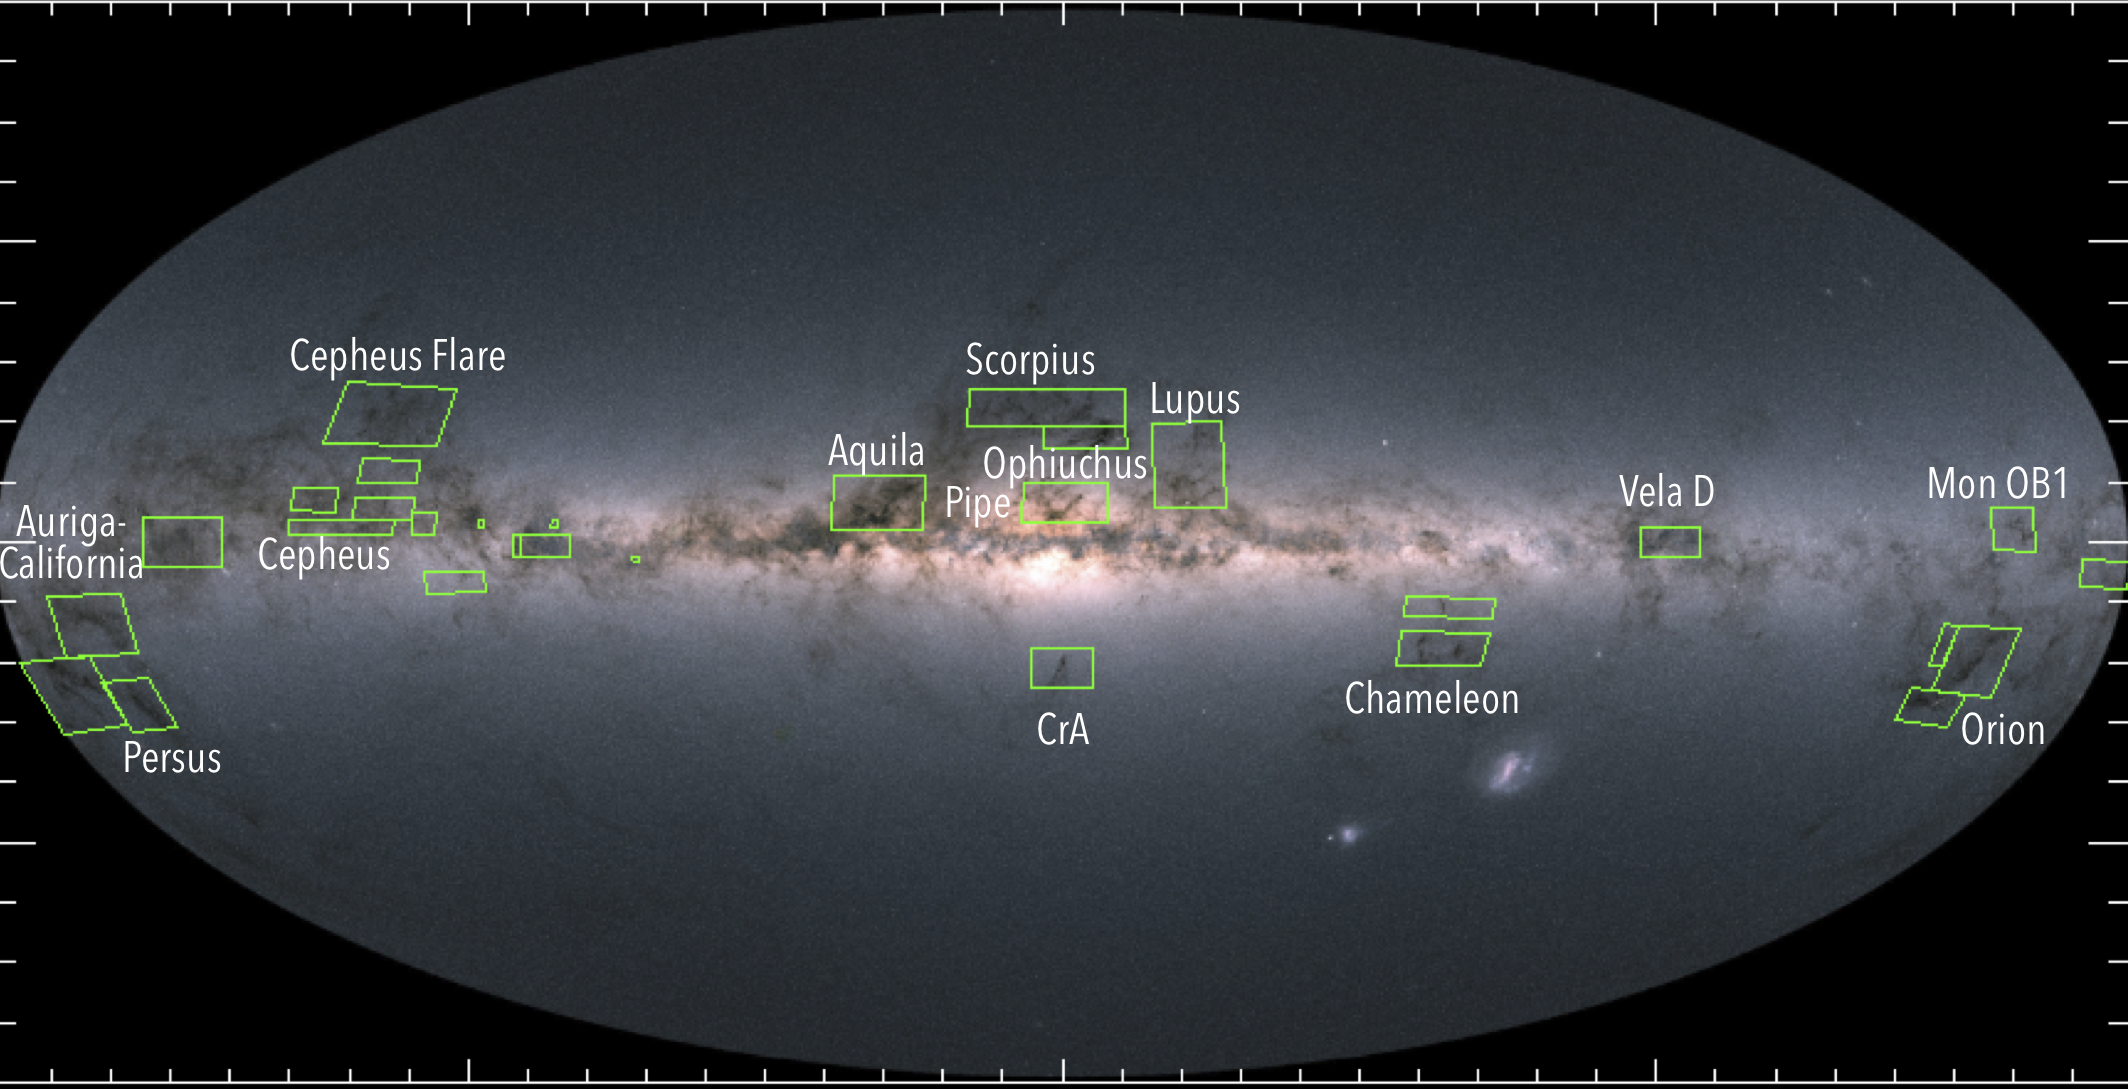

SEDs report the energy emitted by an object across different wavelengths. The SESNA catalog records flux across 8 different wavelengths: 1.2, 1.6, 2.1, 3.6, 4.5, 5.8, 8.0, and 24 $\mu$m.  Because the archive is so huge, we have *sub-sampled* it to play with here. Our sub-sample contains the SEDs for $N = 11,504$ of SESNA's sources.  Additionally, our sub-sample measures $\log(\text{Flux})$, to mitigate some extreme ranges in the data. 

We will use the techniques exercised above to see if we can find any cluster structure in SESNA, but first let's load up the catalog and poke around a bit. 

In [ ]:
## Cell 7.1
## Load the sub-sample from SESNA catalog 
sesna = pd.read_csv('https://utexas.box.com/shared/static/lqyr2vkpbe831f991r1im02ao5lx3vtj.csv')
## If the above line doesn't work for some reason, the ones can be uncommented and tried instead
#import io
#import requests
#s=requests.get("https://utexas.box.com/shared/static/lqyr2vkpbe831f991r1im02ao5lx3vtj.csv").content
#sesna=pd.read_csv(io.StringIO(s.decode('utf-8')))

# Column names containing flux measurements
fluxcols = ['f1.2','f1.6','f2.1','f3.6','f4.5','f5.8','f8.0','f24'] 
display(sesna)

## Strip out the wavelengths (in microns) from the column headers to use for plotting
wvls = [float(col.replace('f','')) for col in fluxcols]

## Plot a few of the SEDs, just to see what they look like 
plt.figure(figsize=(18,9))
plt.subplot(2,2,1)
sns.scatterplot(x=np.log10(wvls), y=sesna.iloc[9,:]).set(title='SED for SESNA Object #10', ylabel='log(Flux)', xlabel=r'wavelength [$\mu$m]', xticks=np.log10(wvls), xticklabels=wvls);
plt.subplot(2,2,2)
sns.scatterplot(x=np.log10(wvls), y=sesna.iloc[99,:]).set(title='SED for SESNA Object #100', ylabel='log(Flux)', xlabel=r'wavelength [$\mu$m]', xticks=np.log10(wvls), xticklabels=wvls);
plt.subplot(2,2,3)
sns.scatterplot(x=np.log10(wvls), y=sesna.iloc[999,:]).set(title='SED for SESNA Object #1000', ylabel='log(Flux)', xlabel=r'wavelength [$\mu$m]', xticks=np.log10(wvls), xticklabels=wvls);
plt.subplot(2,2,4)
sns.scatterplot(x=np.log10(wvls), y=sesna.iloc[9999,:]).set(title='SED for SESNA Object #10000', ylabel='log(Flux)', xlabel=r'wavelength [$\mu$m]', xticks=np.log10(wvls), xticklabels=wvls);

## Don't forget to Standardize! 
sesna = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(sesna), columns=sesna.columns)


## <font color="#e7a23c">7.1</font> SESNA Density Visualizations

Visualizing single SEDs is a very tedious way to get a grasp of any potential cluster structure. To consider the whole sample at once, let's see what our pairwise density plots look like. 

In [ ]:
## Cell 7.2
## Creating a pairs plot of fluxes in the 8 SESNA bands
## This will take a couple of minutes, it's computing 36 different KDEs with over 10k data points
pl = sns.pairplot(data=sesna[fluxcols], diag_kind='kde', plot_kws={"s": 0.5});
pl.map_lower(sns.kdeplot, fill=True);

**<font color="#E74C3C">Can you find any evidence for groups from the scatter plots, or KDEs?</font>** 

**<font color="#E74C3C">If so, how many clusters do you think there might be?</font>**


## <font color="#e7a23c">7.2</font> SESNA Embeddings

As before, we will also use dimension reduction to help guide our intuition about cluster structure within SESNA. Lets compute the PCA, tSNE, and UMAP embeddings to see what they can offer us. 

In [ ]:
## Cell 7.3
## Compute & store SESNA embeddings 
sesna[['pca1','pca2']] = sklearn.decomposition.PCA(n_components=2).fit_transform(sesna[fluxcols])
sesna[['tsne1','tsne2']] = sklearn.manifold.TSNE(n_components=2, random_state=123).fit_transform(sesna[fluxcols])
sesna[['umap1','umap2']] = umap.UMAP(n_components=2, random_state=123).fit_transform(sesna[fluxcols])

In [ ]:
## Cell 7.4
## Visualize the embeddings 

## First with scatterplots 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1',y='pca2',s=2,data=sesna).set(title='PCA Embedding');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1',y='tsne2',s=2,data=sesna).set(title='TSNE Embedding');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1',y='umap2',s=2,data=sesna).set(title='UMAP Embedding');

## Then with KDEs, which can help guide your eye to structure 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.kdeplot(x='pca1',y='pca2',fill=True, data=sesna).set(title='PCA Embedded KDE');
plt.subplot(1,3,2)
sns.kdeplot(x='tsne1',y='tsne2',fill=True, data=sesna).set(title='TSNE Embedded KDE');
plt.subplot(1,3,3)
sns.kdeplot(x='umap1',y='umap2',fill=True, data=sesna).set(title='UMAP Embedded KDE');

In [ ]:
## Cell 7.5
## Exploring parameters for embeddings 

## This is a much bigger dataset than wine! Let's play with the parameters for tSNE & UMAP 
## Does changing the number of neighbors parameters change our embeddings much? 
## note: tSNE calls its "number of neighbors" parameter "perplexity", while UMAP just calls it "n_neighbors"
sesna[['tsne1','tsne2']] = sklearn.manifold.TSNE(n_components=2, random_state=123, perplexity=100).fit_transform(sesna[fluxcols])
sesna[['umap1','umap2']] = umap.UMAP(n_components=2, random_state=123, n_neighbors=100).fit_transform(sesna[fluxcols])

## Visualize the new embeddings, scatterplots + KDEs
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1',y='pca2',s=2,data=sesna).set(title='PCA Embedding');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1',y='tsne2',s=2,data=sesna).set(title='TSNE Embedding');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1',y='umap2',s=2,data=sesna).set(title='UMAP Embedding');

plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.kdeplot(x='pca1',y='pca2',fill=True, data=sesna).set(title='PCA Embedded KDE');
plt.subplot(1,3,2)
sns.kdeplot(x='tsne1',y='tsne2',fill=True, data=sesna).set(title='TSNE Embedded KDE');
plt.subplot(1,3,3)
sns.kdeplot(x='umap1',y='umap2',fill=True, data=sesna).set(title='UMAP Embedded KDE');


It seems like tSNE got a little "tighter" compared to before. Let's keep these embeddings for now (we can revisit later if needed). 

**<font color="#E74C3C">Based on the above, can you identify a plausible range for the number of clusters in SESNA?</font>** 

**<font color="#E74C3C">Store your answers in the variables below:</font>**

In [ ]:
## Cell 7.6
## Guesses for a range of K for SESNA based on density plots + embeddings. 
# Replace with your answers, then run the cell 
Kmin = ? #? 
Kmax = ? #? 

## <font color="#e7a23c">7.3 </font> SESNA Cluster Selection

Using the same function for computing & visualizing cluster validity measures defined above, let's cluster with K-means and GMMs, and see what the measures suggest. 

In [ ]:
## Cell 7.7
## Compute Cluster Validity measures and their Overall Rank for the range of K you specified in Cell 7.6
Krange = range(Kmin, Kmax+1)
sesna_ensdf = ensemble_ClusValidity(Krange, sesna[fluxcols])
display(sesna_ensdf)

**<font color="#E74C3C">What are your conclusions? </font>**

Some of mine: 
- Overall, K-means seems to produce "tighter" clusters, which results in higher values of SIL
- On the other hand, GMMs with full covariance drastically outperform Kmeans according to BIC
- There appears to be a sharp dropoff in SIL after $K=7$, without an equivalently large increase in BIC. This suggest K=7 might be a ceiling for $K$. 

This oppostive behavior (SIL telling one story, BIC telling another) is very common! In these cases, we usually inspect several clusterings on the embeddings to see which look more organized. 

Let's look at K-means & GMM-diag for $K = \{5,6,7\}$. 

In [ ]:
## Cell 7.8
## Cluster SESNA with K-means & GMM-full
## Note that we store the cluster labels from each method with X clusters in column 'KMX' or 'GMMfX' 
## in the sesna data frame for later use 

# First with K-means 
plt.figure(figsize=(21,21))
counter = 1
for k in range(5,8):

    clusmethod = 'KM'+str(k)
    sesna[clusmethod] = sklearn.cluster.KMeans(n_clusters=k, random_state=123, init='k-means++').fit(sesna[fluxcols]).labels_
    
    plt.subplot(3,3,counter)
    sns.scatterplot(x='pca1',y='pca2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='PCA - ' + clusmethod);
    counter += 1

    plt.subplot(3,3,counter)
    sns.scatterplot(x='tsne1',y='tsne2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='TSNE - ' + clusmethod);
    counter += 1
    
    plt.subplot(3,3,counter)
    sns.scatterplot(x='umap1',y='umap2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='UMAP - ' + clusmethod);
    counter += 1

# Next with GMM-full
plt.figure(figsize=(21,21))
counter = 1
for k in range(5,8):
    
    clusmethod = 'GMMf'+str(k)
    sesna[clusmethod] = sklearn.mixture.GaussianMixture(n_components=k, 
                                                        covariance_type='full', 
                                                        init_params='k-means++', 
                                                        random_state=1234).fit(sesna[fluxcols]).predict(sesna[fluxcols])
        
    plt.subplot(3,3,counter)
    sns.scatterplot(x='pca1',y='pca2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='PCA - ' + clusmethod);
    counter += 1

    plt.subplot(3,3,counter)
    sns.scatterplot(x='tsne1',y='tsne2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='TSNE - ' + clusmethod);
    counter += 1
    
    plt.subplot(3,3,counter)
    sns.scatterplot(x='umap1',y='umap2',s=2,hue=clusmethod,data=sesna, palette='Set2').set(title='UMAP - ' + clusmethod);
    counter += 1

**<font color="#E74C3C">Which clustering method seems to have defined groups that are in best agreement with our embeddings?</font>**
 
**<font color="#E74C3C">For this method, what does increasing $K$ do to the clusterings on the embeddings?</font>**



## <font color="#e7a23c">7.4 </font> Comparing SESNA Clusterings to Existing Groupings

The SESNA catalog also contains a group identifier for *some* of its sources. These group labels were assigned through a more tedious process. All sources in the `sesna` dataframe you loaded earlier have associated labels, which we have ignored until now. 

The labels indicate that the object is one of: 
- [Active Galactic Nucleus](https://en.wikipedia.org/wiki/Active_galactic_nucleus) (AGN)
- [Class I Prototstar](https://en.wikipedia.org/wiki/Protostar)
- [Class II Prototstar](https://en.wikipedia.org/wiki/Protostar)
- [PAH Contaminated Sources](https://www.astrochem.org/docs/IAU251_Salama.pdf) (PAH = Polycyclic Aromatic Hydrocarbons)
- [PAH Emitters](https://www.astrochem.org/docs/IAU251_Salama.pdf) (Star-Forming Galaxies)
- [Transition Disks](https://www.aavso.org/transition-disks)


Let's load these existing group labels, and inspect them. 

In [ ]:
## Cell 7.9
## Load known object labels  
sesna_classes = pd.read_csv("https://utexas.box.com/shared/static/7duct17mn3f6175gjcwlpsheqkch08cd.csv")
## If the above line doesn't work for some reason, the ones can be uncommented and tried instead
#import io
#import requests
#s=requests.get("https://utexas.box.com/shared/static/7duct17mn3f6175gjcwlpsheqkch08cd.csv").content
#sesna_classes=pd.read_csv(io.StringIO(s.decode('utf-8')))

## Inspect unique class names and the distribution of their counts 
display(sesna_classes.value_counts().sort_index(ascending=True).to_frame(name='count'))

## Add the class label to the sesna data frame, inspect 
sesna['class'] = sesna_classes
display(sesna)

In [ ]:
## Cell 7.10
## Visualize the existing SESNA groups & your favorite clustering on the embeddings 

## With existing group labels 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1',y='pca2',s=2,hue='class',data=sesna, palette='tab10').set(title='PCA - Existing Groups');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1',y='tsne2',s=2,hue='class',data=sesna, palette='tab10').set(title='TSNE - Existing Groups');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1',y='umap2',s=2,hue='class',data=sesna, palette='tab10').set(title='UMAP - Existing Groups');

## Your favorite clustering ... change hue='XYZ' accordingly 
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
sns.scatterplot(x='pca1',y='pca2',s=2,hue='GMMf6',data=sesna, palette='Set2').set(title='PCA - Clustering');
plt.subplot(1,3,2)
sns.scatterplot(x='tsne1',y='tsne2',s=2,hue='GMMf6',data=sesna, palette='Set2').set(title='TSNE - Clustering');
plt.subplot(1,3,3)
sns.scatterplot(x='umap1',y='umap2',s=2,hue='GMMf6',data=sesna, palette='Set2').set(title='UMAP - Clustering');



**<font color="#E74C3C">How does your clustering compare to the existing group labels?</font>**

**<font color="#E74C3C">Based on this, how do you think clustering can help organize large astronomy surveys?</font>**